In [1]:
#import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.constants import g, R
from typhon.physics import e_eq_water_mk as saturation_pressure

from constants import *
from ode_solver import *
from superdroplets_as_objects import *

plt.rcParams.update({'font.size': 12})

#print(rgas_dry, latent_v)

In [2]:
### initial parcel conditions
w               = 0.5                                           # vertical wind speed [m/s] (dP/dt = w*dP/dz)
z0              = 0                                             # initial z coordinate
temp0, p0       = 273.15, 100000                                # initial temp & pressure
relh0           = 60                                            # initial relative humidity (%)
qc0             = 0                                             # initial liquid water content
cond            = True
pcl0            = [0,0,0]                                       # centre of parcel (x,y,z) in wider domain coords
pclsize         = [0.5,0.5,0.5]                                       # (Lx/2,Ly/2,Lz/2) real dimensions of parcel [m]

### droplet properties (see droplet initialisation for more parameters)
#mus             = [0.2e-6, 0.015e-6]                # [m] geometric mean droplet radius
#sigs            = [1.5, 1.6]                        # geometric std. dev.
#n_as            = [0.75e6, 0.25e6]                  # [m^-3] total no. concentration of droplets
#mus             = [0.075e-6]               
#sigs            = [1.5]                    
#n_as            = [1e9]                  
mus              = [0.02e-6, 0.2e-6, 3.5e-6]               
sigs             = [1.55, 2.3, 2]                    
n_as             = [1e6, 0.3e6, 0.025e6]                  
rspan            = [1e-8, 1e-5]                      # initial range of droplet radii [m]
nsupers          = 10                                # no. of distinct superdrops (different initial radii (evenly spaced between ln(rspan))
nbins            = nsupers                           # no. bins when making histograms

mr_sol         = 0.058443                           # Mr of solute (dry areosol) [Kg/mol]
ionic          = 2                                  # degree ionic dissociation (van't Hoff factor)
rho_sol        = 2200                               # density of dry areosol [Kg m^-3]



# integration params
tspan          = [0, 4000]
t_eval         = np.linspace(tspan[0], tspan[1], 1000)
method         = 'LSODA'
maxtstep       = 0.1 
rtol           = 1e-6                            # relative tolerance (tol) for integration
atols          = [1e-6, 1e-8, 1e-6]                   # absolute tols for [parcel dysnamics, droplet positions]
                                                 # atol for droplet radii varies with initial radii (see atols below)

### resulting values of some variables
pv0 = relh0/100 * saturation_pressure(temp0)     # initial water vapour pressure
qv0 = pv2qv(pv0, p0)                             # initial water mass mixing ratio (mass water/mass dry air)



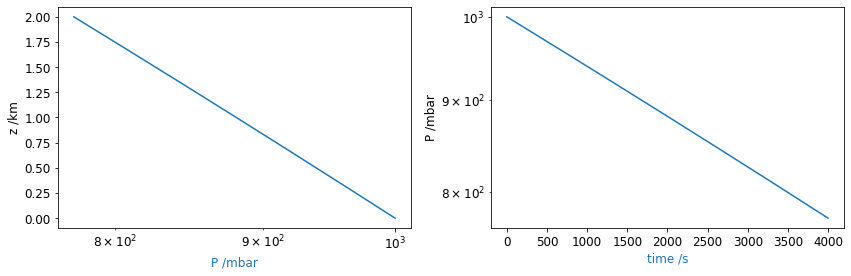

In [3]:
zplt = z0+w*t_eval
pplt = dp_dz_profile(zplt, pprofile=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axs = axs.flatten()

def axplt(ax,x,y,xlab=None,ylab=None, lab=None, i=0):
    ax.plot(x,y, label=lab, color='C'+str(i))
    ax.set_xlabel(xlab, color='C'+str(i))
    ax.set_ylabel(ylab)

axplt(axs[0], pplt/100, zplt/1000, 'P /mbar','z /km', i=0)
axplt(axs[1], t_eval, pplt/100, 'time /s', 'P /mbar', i=0)
axs[0].set_xscale('log')
axs[1].set_yscale('log')

fig.tight_layout()
#plt.close()

Initial Droplet No. Concentration Distribution:



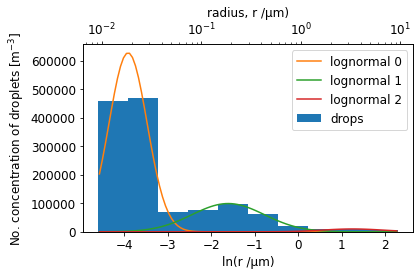

In [4]:
# initialise droplets
for d in range(len(mus)):
    
    mu, sig, n_a = mus[d], sigs[d], n_as[d]
    lnr1, lnnorm1, wdths1, edgs1 = get_lnr_dist(rspan, nsupers, n_a, mu, sig)
    r0 = np.e**lnr1
    eps1 = np.asarray([int(n) for n in lnnorm1*wdths1])

    if d==0:
        eps = eps1
    else:                        
        eps = eps+eps1
        
m_sol = rho_sol*4/3*np.pi*r0**3                          # assuming initially dry areosol droplets
        
print('Initial Droplet No. Concentration Distribution:\n')
fig, ax = plt.subplots(figsize=(6,4))
plot_histogram(ax, r0, eps, rspan, nbins, lab='drops', c='C0')          # plot initial distirbution as histogram
for d in range(len(mus)):
    pltlnr, pltnorm, pltwdths = get_lnr_dist(rspan,                     # plot x10 more bins lognormal for reference
                    nbins*10, n_as[d], mus[d], sigs[d])[0:3]
    ax.plot(pltlnr+np.log(1e6), pltnorm*pltwdths*10, 
                     color='C'+str(d+1), label='lognormal '+str(d)) 
raxes4dists(ax, np.log(r0), eps, edgs1)
ax.legend()
plt.tight_layout()


In [5]:
### ODE solution
drops = [] 
for i in range(nsupers):
    
    drop = Superdroplet(r0[i], eps[i], m_sol[i], 
                    rho_l, rho_sol, mr_sol, ionic)
    drop.init_positions(pclsize)   
    drops.append(drop)                                        # list of all superdroplet objects
    

atol = [atols[0]]*5+[atols[1]]*nsupers+[atols[2]]*nsupers*3
#atol = [atols[0]]*5+list(drops.r0)+[atols[1]]*nsupers*3        #atol for droplet radii is their initial value
args = [w, drops, pclsize, cond]
y0 = [z0, temp0, p0, qv0, qc0]
y0 += same_attr_from_objs(drops, 'r0')
y0 += same_attr_from_objs(drops, 'coords0')

        
if nsupers != len(drops):
    print('warning nsupers != number of different superdroplet radii')
    print(nsupers, len(drops))

    

In [6]:
sol = solve_ivp(rising_parcel, tspan, 
                y0, method=method, t_eval=t_eval, args=args,
                   max_step=maxtstep, rtol=rtol, atol=atol)    

(1000,) (1000,) (1000,) (1000,) (1000,)
(10, 1000) (10, 3, 1000)

cloud base at 846.85m, s=0.0000
cloud max at 962.96m, s=0.0405
cloud max is 116.12m above base



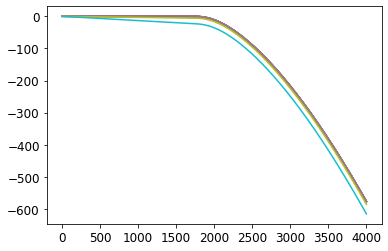

In [7]:
time = sol.t
z, temp, p, qv, qc = sol.y[:5]
r = sol.y[5:nsupers+5]
xyz = sol.y[nsupers+5:nsupers*4+5]
xyz = np.reshape(xyz, [nsupers,3, len(time)])
theta = dry_pot_temp(temp, p, qv)

print(z.shape, temp.shape, p.shape, qv.shape, qc.shape)
print(r.shape, xyz.shape)

### other parcel thermodynamic variables
dry_adia = temp0*(p/p0)**(rgas_dry/cp_dry)
dry_adia_theta = dry_adia*(p0/p)**(rgas_dry/cp_dry)
pv = qv*p/(mr_ratio + qv) 
psat = saturation_pressure(temp)
relh = pv/psat
qsat = mr_ratio * psat/(p-pv) 
s = qv/qsat - 1      

### cloud base and max supersaturation
basei = np.argmin(abs(s-0))
maxi = np.argmax(s)
cloud_base = z[basei]
cloud_max = z[maxi]
print('\ncloud base at {:.2f}m, s={:.4f}'.format(cloud_base, s[basei]))
print('cloud max at {:.2f}m, s={:.4f}'.format(cloud_max, s[maxi]))
print('cloud max is {:.2f}m above base\n'.format(cloud_max-cloud_base))  


for i in range(nsupers): 
    plt.plot(time, xyz[i,2,:])
    


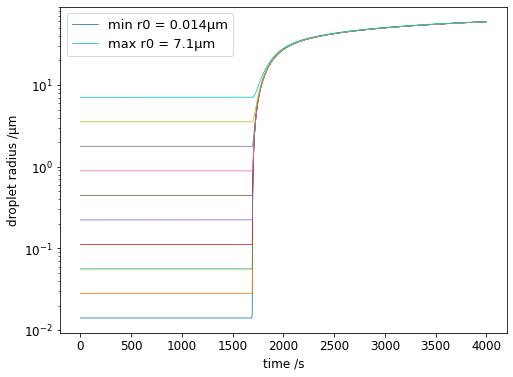

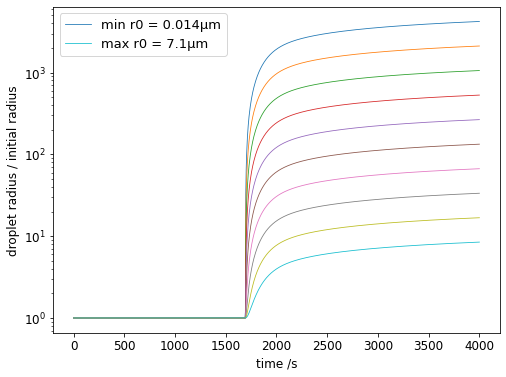

In [8]:
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(8,6))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
for i in range(nsupers):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax.plot(time, r[i]*1e6, linewidth=0.8, label=label)
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius /\u03BCm')
ax.set_yscale('log')
ax.legend(fontsize=13)

fig, ax = plt.subplots(figsize=(8,6))
#cols = ['b','g','r','c','m','y','k']
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
labs2 = [None]*nsupers
for i in range(nsupers):    
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == len(r)-1:
        label = 'max r0 = '+labs[i]
    ax.plot(time, r[i]/r[i,0], linewidth=0.8, label=label) #,color=cols[i])
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius / initial radius')
ax.set_yscale('log')
ax.legend(fontsize=13)

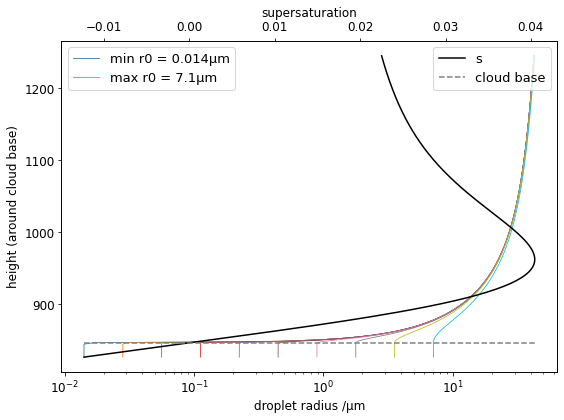

In [9]:
lim1 = basei-10
lim2 = np.argmin(abs(z-cloud_base-400))
### plots of droplet radii growth
fig, ax = plt.subplots(figsize=(8,6))
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
for i in range(nsupers):
    label = None
    if i == 0:
        label = 'min r0 = '+labs[i]
    elif i == nsupers-1:
        label = 'max r0 = '+labs[i]
    ax.plot((r[i]*1e6)[lim1:lim2], z[lim1:lim2], linewidth=0.8, label=label)
ax1 = ax.twiny()
ax1.plot(s[lim1:lim2], z[lim1:lim2], 
         linewidth=1.5, color='k', label='s')
ax1.hlines(z[basei], np.amin(s[lim1:lim2]), np.amax(s[lim1:lim2]), 
         color='gray', linestyle='--', label='cloud base')

ax.set_ylabel('height (around cloud base)')
ax.set_xlabel('droplet radius /\u03BCm')
ax1.set_xlabel('supersaturation')
ax.set_xscale('log')
ax.legend(fontsize=13, loc='upper left')
ax1.legend(fontsize=13,  loc='upper right')

fig.tight_layout()

In [10]:
#
#means, stds, skews, kurts = distribution_stats(drops, r=r)
#ameans, astds, askews, akurts = distribution_stats(r=r, geo=False)
#
#mean0, std0, skew0, kurt0 = distribution_stats(drops, r=r0)
#print('initial distribution (geometric) stats:')
#print('mean, stddev: {:.3g}m, {:.3g}'.format(mean0, std0))
#print('skew: {:.3g}'.format(skew0))
#print('kurtosis : {:.3g}\n'.format(kurt0))
#
#fig, ax = plt.subplots(figsize=(8,6))
##ax.fill_between(time, means*stds,
##        means/stds, alpha=0.2, color='olive')
##ax.fill_between(time, ameans-astds, 
##        ameans+astds, alpha=0.1, color='pink')
##ax.plot(time, means, label='geometric', color='olive')
##ax.plot(time, ameans, label='arithmetic', color='pink')
#errs = [means-means/stds, means*stds-means]
#ax.errorbar(time, means, yerr=errs, capsize=5, 
#        errorevery=100, label='geometric', color='olive')
#ax.errorbar(time, ameans, yerr=astds, capsize=5, 
#        errorevery=100, label='arithmetic', color='pink')
#ax.set_xlabel('time /s')
#ax.set_ylabel('mean droplet radius /\u03BCm')
#ax.set_yscale('log')
#ax.legend(fontsize=13)
#
#fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(18,6), sharex=True)
#ax1.plot(time, skews, label='geometric', color='olive')
##ax1.plot(time, askews, label='arithmetic', color='pink')
#ax1.set_ylabel('Fisher-Pearson Skew')
##ax1.set_yscale('log')
#ax1.set_ylabel('Fisher-Pearson Skew')
#
#ax2.plot(time, kurts, label='geometric', color='olive')
##ax2.plot(time, akurts, label='arithmetic', color='pink')
#ax2.set_ylabel('Kurtosis (Tailedness)')
#for ax in [ax1, ax2]:
#    ax.set_xlabel('time /s')

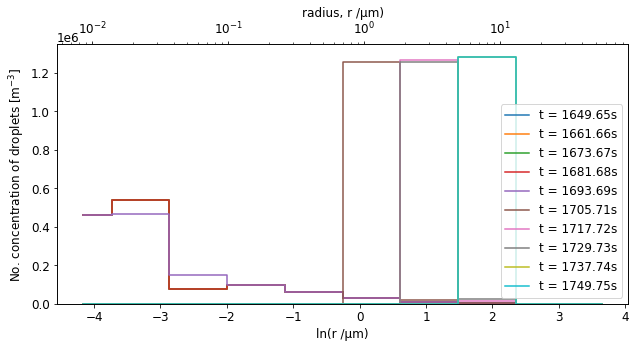

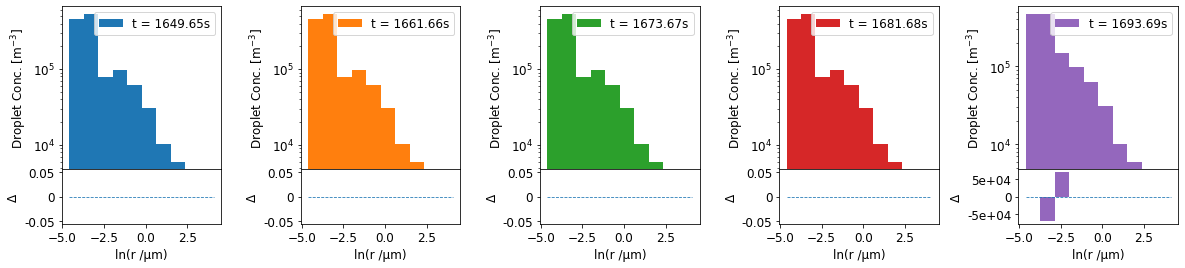

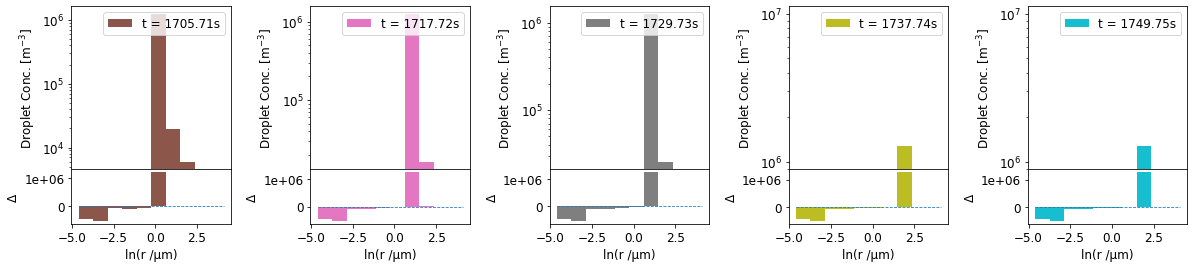

In [11]:

eps = same_attr_from_objs(drops, 'eps')

fig, ax = plt.subplots(figsize=(9,5))
nplts = 10
rspan = [rspan[0], np.amax(r)]
#tplt = np.linspace(tspan[0], tspan[1], nplts)
tplt = np.linspace(1650, 1750, nplts)
for i in range(nplts):
    ind = np.argmin(abs(time-tplt[i]))
    tlab = 't = {:.2f}s'.format(time[ind])
    c = 'C'+str(i)
    hist, wdths, lnr, hedgs = radii2dist(r[:,ind], eps, rspan, nbins)
    ax.step(lnr+np.log(1e6), hist, label=tlab, where='mid')
ax, ax1 = raxes4dists(ax, lnr, hist, hedgs)
#ax.set_yscale('log')
ax.legend()
plt.tight_layout()

tplts = [tplt[:nplts//2], tplt[nplts//2:]]
nplts = nplts//2
sn = 0
for tplt in tplts:
    gd = dict(width_ratios=[1]*nplts,
            height_ratios=[3,1],
             hspace=0.001, wspace=0.5)
    fig, axs = plt.subplots(ncols=nplts, nrows=2, 
                    figsize=(20,4), gridspec_kw=gd, sharex=True)
    for i, t in enumerate(tplt):
        ind = np.argmin(abs(time-t))
        tlab = 't = {:.2f}s'.format(time[ind])
        c, rw, cl = 'C'+str(sn), 0, i
        sn+=1
        hvals, hwdths, hcens = plot_histogram(axs[rw,cl], r[:,ind], 
                                    eps, rspan, nbins, tlab, c)[:3]
        if i == 0: 
            hvals0 = radii2dist(r[:,0], eps, rspan, nbins)[0]
        axs[rw,cl].set_yscale('log')
        axs[rw+1,cl].bar(hcens+np.log(1e6), hvals-hvals0, hwdths, color=c) 
        axs[rw+1,cl].set_xlabel('ln(r /\u03BCm)')
        axs[rw+1,cl].set_ylabel('\u0394')
        axs[rw+1,cl].set_yticks([k for k in axs[rw+1,cl].get_yticks()])
        yticklabs = ['{:.2g}'.format(k) for k in axs[rw+1,cl].get_yticks()]
        axs[rw+1,cl].set_yticklabels(yticklabs)
        axs[rw+1,cl].hlines(0, np.log(rspan[0])+np.log(1e6),
                            np.log(rspan[-1])+np.log(1e6), linestyle='--', linewidth=0.8)

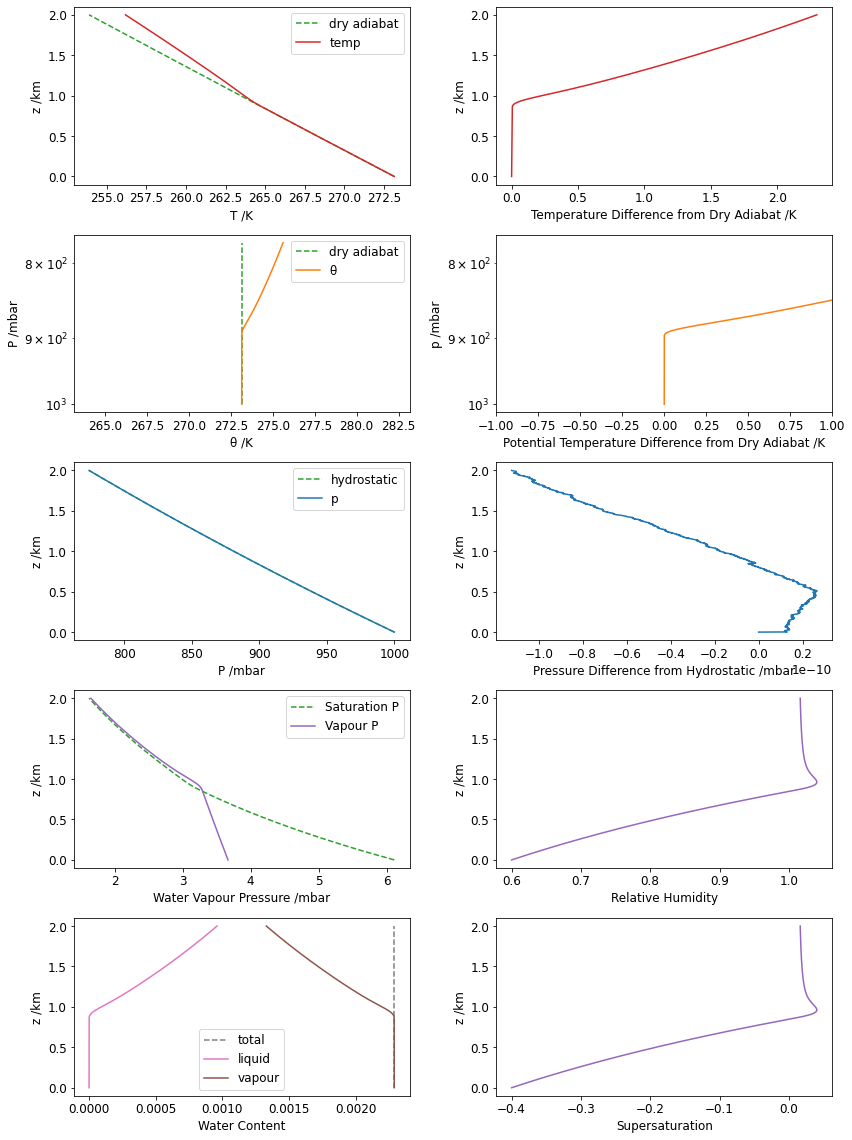

In [12]:
### plots of z, Temp, theta and pressure profiles

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,16))
axs = axs.flatten()

def axplt(ax, x, y, xlab=None, ylab=None, lab=None, c=0, l='-'):
    ax.plot(x,y, label=lab, color='C'+str(c), linestyle=l)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axplt(axs[0], dry_adia, z/1000, lab='dry adiabat', c=2, l='--')
axplt(axs[4], pplt/100, z/1000, lab='hydrostatic', c=2, l='--')
axplt(axs[2], dry_adia_theta, p/100, lab='dry adiabat', c=2, l='--')
axplt(axs[0], temp, z/1000, 'T /K', 'z /km', 'temp', 3)
axplt(axs[4], p/100,z/1000,'P /mbar','z /km', 'p', 0)
axplt(axs[2], theta, p/100,'\u03B8 /K','P /mbar', '\u03B8', 1)
axplt(axs[6], psat/100, z/1000,lab='Saturation P', c=2, l='--')
axplt(axs[6], pv/100, z/1000, 'Water Vapour Pressure /mbar','z /km', 'Vapour P', c=4)
axplt(axs[8], qv+qc, z/1000, lab='total', c=7, l='--')
axplt(axs[8], qc, z/1000, lab='liquid', c=6)
axplt(axs[8], qv, z/1000, 'Water Content','z /km', 'vapour', c=5)

axplt(axs[1], temp-dry_adia, z/1000, 
      'Temperature Difference from Dry Adiabat /K', 'z /km', c=3)
axplt(axs[5], (p-pplt)/100, z/1000, 
      'Pressure Difference from Hydrostatic /mbar', 'z /km', c=0)
axplt(axs[3], (theta-dry_adia_theta), p/100, 
      'Potential Temperature Difference from Dry Adiabat /K', 'p /mbar', c=1)
axplt(axs[7], pv/psat, z/1000, 
      'Relative Humidity' ,'z /km', c=4)
axplt(axs[9], s, z/1000, 
      'Supersaturation' ,'z /km', c=4)

for ax in axs[::2]:
    ax.legend()
axs[2].set_yscale('log')
axs[2].invert_yaxis()
axs[3].set_yscale('log')
axs[3].invert_yaxis()

axs[2].set_xlim([theta[0]-10,theta[0]+10])
axs[3].set_xlim([-1,1])

#psat = saturation_pressure(temp)
#axplt(axs[3], psat/100, z/1000,'saturation curve /mbar', 'z /km')

fig.tight_layout()
#plt.close()



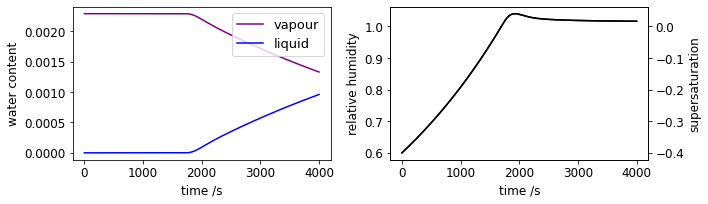

In [13]:
### plots of time evolution of water as parcel rises

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axs2 = axs[1].twinx()

axs[0].plot(time, qv, color='purple', label='vapour')
axs[0].plot(time, qc, color='blue', label='liquid')
axs[1].plot(time, relh, color='k')
axs2.plot(time, s, color='k')
axs[0].set_xlabel('time /s')
axs[0].set_ylabel('water content')
axs[1].set_xlabel('time /s')
axs[1].set_ylabel('relative humidity')
axs2.set_ylabel('supersaturation')
plt.tight_layout()
axs[0].legend(fontsize=13, loc='upper right')
plt.show()

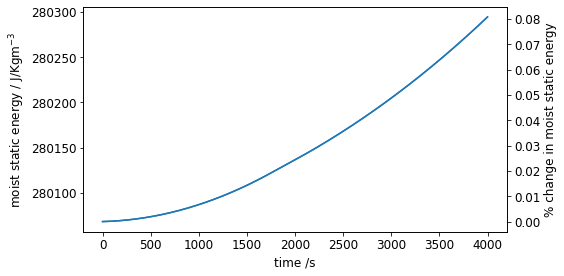

In [14]:
### Moist Static Energy Conservation

def moist_static_energy(z, temp, qv=0):
    ''' calculate the moist static energy /m^3
        (not assuming dry air cp) '''
    
    return  g*z + latent_v*qv + cp_dry*temp


mse = moist_static_energy(z, temp, qv)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(time, mse)
ax1 = ax.twinx()
ax1.plot(time, ((mse-mse[0])/mse[0]*100))
ax.set_ylabel('moist static energy / J/Kgm$^{-3}$')
ax1.set_ylabel('% change in moist static energy')
ax.set_xlabel('time /s')

plt.tight_layout()
plt.show()